# Visualization of Harmonics

## Importing Libaries

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scipy.integrate as integrate

import datetime
import matplotlib
matplotlib.rc('axes',edgecolor='#454545')


## Defining Base Functions

In [2]:

forms = {
    "dc": lambda x, magnitude: magnitude,
    "sin": lambda x, magnitude: magnitude*np.sin(x),
    "triangular": lambda x, magnitude: 2*magnitude*x/np.pi if (x%np.pi)<np.pi/2 else 2*magnitude-2*magnitude*x/np.pi,
}

def produce_waveforms(t, T, magnitude, waveform, alpha = 0, beta = np.pi, rectified = True, power = 1):
    pos = (2*(t/T) - 2*(t//T))*np.pi
    if rectified == False:
        sign = 1 if pos < np.pi else -1
    else:
        sign = 1 
        
    if alpha<(pos%np.pi)<=beta:
        return pow(sign*forms[waveform](pos%np.pi, magnitude), power)
    else:
        return 0


## Setting parameters

In [3]:
f = 50
T = 1/f
time_interval = 0.04
n_points = 1000
harmonic_order = 50
magnitude = 100

waveform = "dc"
alpha = 1*np.pi/6
beta = 5*np.pi/6
rectified = False
power = 1

lb = 0
ub = T
rounding = 10


## Plotting Base Function

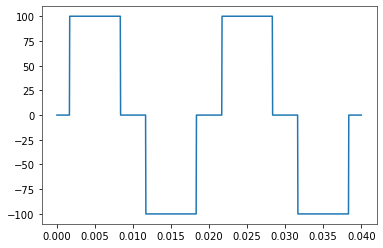

In [4]:
x_axis = np.linspace(0,time_interval, n_points)
y_axis = [produce_waveforms(t, T, magnitude, waveform, alpha, beta, rectified, power) for t in x_axis]

plt.plot(x_axis, y_axis)

## Defining Fourier Transform Functions

In [5]:
def an_f(t, f, T, n, magnitude, waveform, alpha, beta, rectified, power):
    func=produce_waveforms(t, T, magnitude, waveform, alpha, beta, rectified, power)/(T/2)
    return func*np.cos(n*2*np.pi*f*t)
def bn_f(t, f, T, n, magnitude, waveform, alpha, beta, rectified, power):
    func=produce_waveforms(t, T, magnitude, waveform, alpha, beta, rectified, power)/(T/2)
    return func*np.sin(n*2*np.pi*f*t)

def an(x_axis, coef, n, f):
    return coef*np.cos(n*2*np.pi*f*x_axis)
def bn(x_axis, coef, n, f):
    return coef*np.sin(n*2*np.pi*f*x_axis)


def evalute_ft(f, T, time_interval, n_points, harmonic_order, magnitude, waveform, alpha, beta, rectified, power, lb, ub, rounding, x_axis, y_axis):    
    a_0 = round((1/T) *integrate.quad(produce_waveforms, lb, ub, args=(T, magnitude, waveform, alpha, beta, rectified, power))[0], rounding)
    a_coefs = [round(integrate.quad(an_f, lb, ub, args=(f, T, n, magnitude, waveform, alpha, beta, rectified, power))[0], rounding) for n in range(1,harmonic_order+1)]
    b_coefs = [round(integrate.quad(bn_f, lb, ub, args=(f, T, n, magnitude, waveform, alpha, beta, rectified, power))[0], rounding) for n in range(1,harmonic_order+1)]

    total_a = list()
    total_b = list()
    for n in range(harmonic_order):
        total_a.append(an(x_axis, a_coefs[n], n+1, f))
        total_b.append(bn(x_axis, b_coefs[n], n+1, f))
    
    coeffients = pd.DataFrame([a_coefs, b_coefs]).T
    coeffients.columns = ["An", "Bn"]
    coeffients.index = [i+1 for i in range(harmonic_order)]
    
    an_values = pd.DataFrame(total_a).T
    an_values.columns = ["An"+str(i+1) for i in range(harmonic_order)]
    an_values.index = x_axis
    
    bn_values = pd.DataFrame(total_b).T
    bn_values.columns = ["Bn"+str(i+1) for i in range(harmonic_order)]
    bn_values.index = x_axis
    
    values = {"a_0": a_0,
              "an" : an_values,
              "bn" : bn_values}
    res = a_0 + an_values.sum(axis = 1) + bn_values.sum(axis = 1)
    res.name = "Fourier Series"
    res.index = x_axis
    res = res.to_frame()
    res["Orjinal Function"] = y_axis
    res["Sum of Ans"] = sum(total_a)
    res["Sum of Bns"] = sum(total_b)
    res["A0 (DC Component)"] = a_0

    return coeffients, values, res 

    

## Fourier Transform outputs

In [6]:
coeffients, values, res  = evalute_ft(f, T, time_interval, n_points, harmonic_order, magnitude, waveform, alpha, beta, rectified, power,
                                      lb, ub, rounding, x_axis, y_axis)
print("DC component is ", values["a_0"], end = "\n\n")
print("An and Bn coeffients are shown up to {} in the followings.".format(harmonic_order), end = "\n\n")
print(coeffients[coeffients != 0].dropna(how = "all").fillna(0))

DC component is  0.0

An and Bn coeffients are shown up to 50 in the followings.

     An          Bn
1   0.0  110.265779
5   0.0  -22.053156
7   0.0  -15.752254
11  0.0   10.024162
13  0.0    8.481983
17  0.0   -6.486222
19  0.0   -5.803462
23  0.0    4.794164
25  0.0    4.410631
29  0.0   -3.802268
31  0.0   -3.556961
33  0.0   -0.003116
35  0.0    3.150451
37  0.0    2.980156
39  0.0    0.003116
41  0.0   -2.689409
43  0.0   -2.564321
45  0.0   -0.003116
47  0.0    2.346081
49  0.0    2.250322


In [7]:
def rms_main(lb, ub, T, magnitude, waveform, alpha, beta, rectified, power, rounding):
    val = round((1/T) *integrate.quad(produce_waveforms, lb, ub, args=(T, magnitude, waveform, alpha, beta, rectified, power*2))[0], rounding)
    return pow(val,0.5)
def average_main(lb, ub, T, magnitude, waveform, alpha, beta, rectified, power, rounding):
    res = round((1/T) *integrate.quad(produce_waveforms, lb, ub, args=(magnitude, waveform, alpha, beta, rectified, power))[0], rounding)
    return res

def rms_val_harmonics(coeffients):
    harmonic_magnitudes = coeffients.pow(2).sum(axis = 1).pow(0.5)
    rms_harmonics_values = harmonic_magnitudes.div(pow(2,0.5))
    harmonic_angles = coeffients.apply(lambda x: 0 if (x[0]==0) or (x[1] == 0) else  np.arctan(x[0]/x[1]),axis=1)
    return harmonic_magnitudes, rms_harmonics_values, harmonic_angles

def rms_function(rms_harmonics_values):
    return pow(rms_harmonics_values.pow(2).sum(), 0.5)


def thd(rms_harmonics_values):
    rms_value = rms_function(rms_harmonics_values)
    return 100 * pow(pow(rms_value,2) - pow(rms_harmonics_values.iloc[0],2), 0.5) / rms_harmonics_values.iloc[0]

def crest_factor(peak_value, rms_value): # in our case it is equal to magnitude (always)
    return 100*peak_value/rms_value

def distortion_factor(rms_harmonics_values):
    rms_value = rms_function(rms_harmonics_values)
    fundemental = rms_harmonics_values.iloc[0]
    return 100*fundemental / rms_value

harmonic_magnitudes, rms_harmonics_values, harmonic_angles = rms_val_harmonics(coeffients)
RMS = rms_main(lb, ub, T, magnitude, waveform, alpha, beta, rectified, power, rounding)
RMS_eval = rms_function(rms_harmonics_values)
Average = average_main(lb, ub, T, magnitude, waveform, alpha, beta, rectified, power, rounding)
THD = thd(rms_harmonics_values)
CrestFactor = crest_factor(magnitude, RMS)
DistortionFactor = distortion_factor(rms_harmonics_values)

res["RMS"] = RMS
res["RMS calculated"] = RMS_eval

print("RMS value of function: ", RMS)
print("RMS value of evaluated fourier transform: ", RMS_eval)
print("Average value of function: ", Average)
print("THD value of evaluated fourier transform: ", THD)
print("Crest Factor of function: ", CrestFactor)
print("Distortion Factor: ", DistortionFactor)

index = dict({i:round(j, 3) for i,j in zip(["THD", "CrestFactor", "DistortionFactor"], [THD, CrestFactor, DistortionFactor])})
info = "THD (%): {}\nCrest Factor (%): {}\nDistortion Factor (%): {}".format(index["THD"], index["CrestFactor"], index["DistortionFactor"])


RMS value of function:  81.64965809277281
RMS value of evaluated fourier transform:  81.40616265745359
Average value of function:  0.0
THD value of evaluated fourier transform:  30.015291478343034
Crest Factor of function:  122.4744871391586
Distortion Factor:  95.77859658056006


## Combining functions in one place

In [8]:
def evaluate_harmonic_indices(coeffients, lb, ub, T, magnitude, waveform, alpha, beta, rectified, power, rounding, res, print_= True):
    harmonic_magnitudes, rms_harmonics_values, harmonic_angles = rms_val_harmonics(coeffients)
    RMS = rms_main(lb, ub, T, magnitude, waveform, alpha, beta, rectified, power, rounding)
    RMS_eval = rms_function(rms_harmonics_values)
    Average = average_main(lb, ub, T, magnitude, waveform, alpha, beta, rectified, power, rounding)
    THD = thd(rms_harmonics_values)
    CrestFactor = crest_factor(magnitude, RMS)
    DistortionFactor = distortion_factor(rms_harmonics_values)
    if print_:
        print("RMS value of function: ", RMS)
        print("RMS value of evaluated fourier transform: ", RMS_eval)
        print("Average value of function: ", Average)
        print("THD value of evaluated fourier transform: ", THD)
        print("Crest Factor of function: ", CrestFactor)
        print("Distortion Factor: ", DistortionFactor)
    res["RMS"] = RMS
    res["RMS calculated"] = RMS_eval
    index = dict({i:round(j, 3) for i,j in zip(["THD", "CrestFactor", "DistortionFactor"], [THD, CrestFactor, DistortionFactor])})
    info = "THD (%): {}\nCrest Factor (%): {}\nDistortion Factor (%): {}".format(index["THD"], index["CrestFactor"], index["DistortionFactor"])
    return info




## Plotting

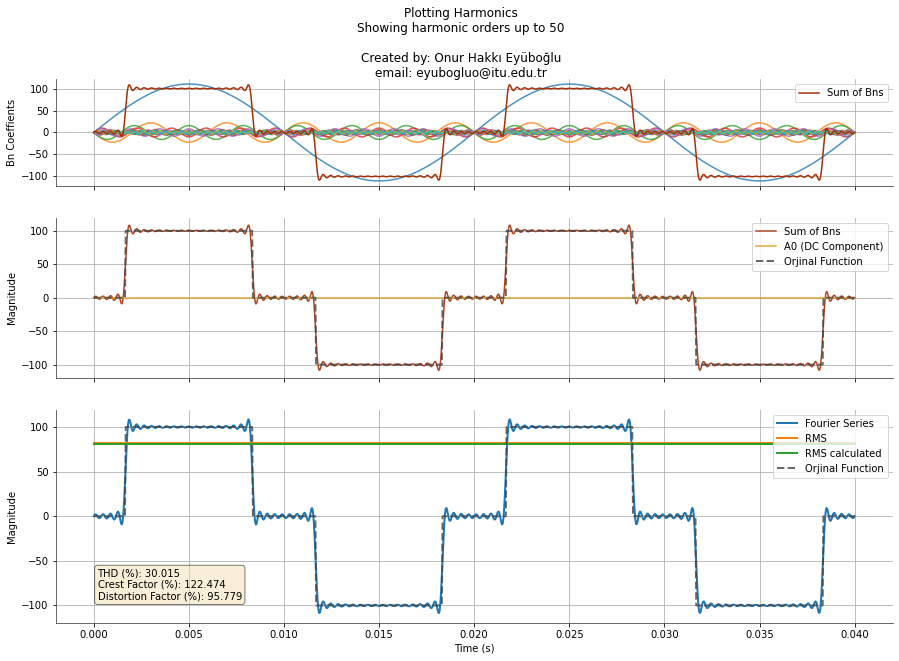

In [9]:
def plotting(coeffients, values, res, info):
    main_colors = ["#107764", "#a62f07", "#de9e23"]
    plot_no = 4
    no_a = False
    no_b = False
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    if values["an"].sum().sum() == 0:
        plot_no -= 1
        no_a = True
    if values["bn"].sum().sum() == 0:
        plot_no -= 1
        no_b = True
       
    if plot_no == 4:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, gridspec_kw={'height_ratios': [2,2,3,4]}, figsize = (15,10), sharex=True,
                                                facecolor='white')
        values["an"][values["an"].sum()[values["an"].sum() != 0].index].plot(ax=ax1, legend=False, grid=True, alpha = 0.8)
        res["Sum of Ans"].plot(ax=ax1, legend=True, grid=True, color=main_colors[0])

        values["bn"][values["bn"].sum()[values["bn"].sum() != 0].index].plot(ax=ax2, legend=False, grid=True, alpha = 0.8)
        res["Sum of Bns"].plot(ax=ax2, legend=True, grid=True, color=main_colors[1])

        res[["Sum of Ans","Sum of Bns", "A0 (DC Component)"]].plot(ax = ax3, legend=True, grid=True, color=main_colors, alpha = 0.9)
        res["Orjinal Function"].plot(ax=ax3, legend=True, grid=True, color="#454545", linestyle="dashed", linewidth=2, alpha = 0.8)

        res[["Fourier Series", "RMS", "RMS calculated"]].plot(ax = ax4, legend=True, grid=True, linewidth=2)
        res["Orjinal Function"].plot(ax=ax4, grid=True, color="#454545", linestyle="dashed", linewidth=2, alpha = 0.8).legend(loc=1)
        
        ax1.set_ylabel("An Coeffients")
        ax2.set_ylabel("Bn Coeffients")
        ax3.set_ylabel("Magnitude")
        ax4.set_ylabel("Magnitude")
        ax4.set_xlabel("Time (s)")
        ax4.text(0.05, 0.1, info, transform=ax4.transAxes, fontsize=10,
             verticalalignment='bottom', bbox=props)
        ax4.spines["right"].set_visible(False)
        ax4.spines["top"].set_visible(False)


    elif plot_no == 3:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2,3,4]}, figsize = (15,10), sharex=True,
                                           facecolor='white')
        if no_a == True:
            values["bn"][values["bn"].sum()[values["bn"].sum() != 0].index].plot(ax=ax1, legend=False, grid=True, alpha = 0.8)
            res["Sum of Bns"].plot(ax=ax1, legend=True, grid=True, color=main_colors[1])
            ax1.set_ylabel("Bn Coeffients")
            columns = ["Sum of Bns", "A0 (DC Component)"]
            colors = [main_colors[1], main_colors[2]]
        if no_b == True:
            values["an"][values["an"].sum()[values["an"].sum() != 0].index].plot(ax=ax1, legend=False, grid=True, alpha = 0.8)
            res["Sum of Ans"].plot(ax=ax1, legend=True, grid=True, color=main_colors[0])
            ax1.set_ylabel("An Coeffients")
            columns = ["Sum of Ans", "A0 (DC Component)"]
            colors = [main_colors[0], main_colors[2]]
        
        res.loc[:,columns].plot(ax = ax2, legend=True, grid=True, color=colors, alpha = 0.9)
        res["Orjinal Function"].plot(ax=ax2, legend=True, grid=True, color="#454545", linestyle="dashed", linewidth=2, alpha = 0.8)

        res[["Fourier Series", "RMS", "RMS calculated"]].plot(ax = ax3, legend=True, grid=True, linewidth=2)
        res["Orjinal Function"].plot(ax=ax3, grid=True, color="#454545", linestyle="dashed", linewidth=2, alpha = 0.8).legend(loc=1)

        ax2.set_ylabel("Magnitude")
        ax3.set_ylabel("Magnitude")
        ax3.set_xlabel("Time (s)")
        ax3.text(0.05, 0.1, info, transform=ax3.transAxes, fontsize=10,
             verticalalignment='bottom', bbox=props)


    #fig.subplots_adjust(hspace=0.01)
    
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)

    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    
    title = "Plotting Harmonics\nShowing harmonic orders up to {}\n\nCreated by: Onur Hakkı Eyüboğlu\nemail: eyubogluo@itu.edu.tr".format(harmonic_order)
    fig.suptitle(title)
    
    fig.savefig(datetime.datetime.now().strftime("%d%m%y%H%M%S")+".png", dpi =600)
    

plotting(coeffients, values, res, info)


## All in one cell

DC component is  0.0

An and Bn coeffients are shown up to 40 in the followings.

           An    Bn
1  -22.281692  35.0
3   22.281692   0.0
5   -7.427231   0.0
7    7.427231   0.0
9   -4.456338   0.0
11   4.456338   0.0
13  -3.183099   0.0
15   3.183099   0.0
17  -2.475744   0.0
19   2.475744   0.0
21  -2.025608   0.0
23   2.025608   0.0
25  -1.713976   0.0
27   1.713976   0.0
29  -1.485446   0.0
31   1.485446   0.0
33  -1.310688   0.0
35   1.310688   0.0
37  -1.172721   0.0
39   1.172721   0.0
RMS value of function:  35.0
RMS value of evaluated fourier transform:  34.822384500344796
Average value of function:  0.0
THD value of evaluated fourier transform:  63.93677147878951
Crest Factor of function:  200.0
Distortion Factor:  84.25131813163759
{ a_n : [-22.3, 0.0, 22.3, 0.0, -7.4, 0.0, 7.4, 0.0, -4.5, 0.0, 4.5, 0.0, -3.2, 0.0, 3.2, 0.0, -2.5, 0.0, 2.5, 0.0, -2.0, 0.0, 2.0, 0.0, -1.7, 0.0, 1.7, 0.0, -1.5, 0.0, 1.5, 0.0, -1.3, 0.0, 1.3, 0.0, -1.2, 0.0, 1.2, 0.0] , b_n : [35.0, 0.0, 0.

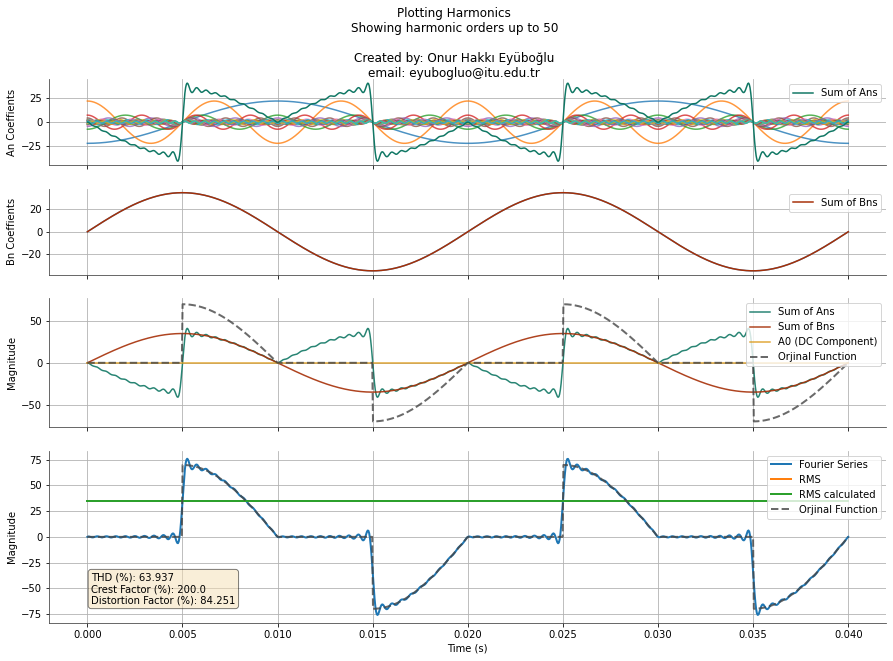

In [10]:
def set_parameters(f = 50, time_interval = 0.04, n_points = 1000, 
                   harmonic_order = 40, magnitude = 70, waveform = "sin",
                   alpha = 3*np.pi/6,
                   beta = 6*np.pi/6,
                   rectified = False,
                   power = 1,
                   lb = 0, rounding = 10):
    T = 1/f
    ub = T
    return f, T, time_interval, n_points, harmonic_order, magnitude, waveform, alpha, beta, rectified, power, lb, ub, rounding

def main():
    f, T, time_interval, n_points, harmonic_order, magnitude, waveform, alpha, beta, rectified, power, lb, ub, rounding = set_parameters()
    x_axis = np.linspace(0,time_interval, n_points)
    y_axis = [produce_waveforms(t, T, magnitude, waveform, alpha, beta, rectified, power) for t in x_axis]
    coeffients, values, res = evalute_ft(f, T, time_interval, n_points, harmonic_order,
                                         magnitude, waveform, alpha, beta, rectified, power, lb, ub, rounding, x_axis, y_axis)
    
    print("DC component is ", values["a_0"], end = "\n\n")
    print("An and Bn coeffients are shown up to {} in the followings.".format(harmonic_order), end = "\n\n")
    print(coeffients[coeffients != 0].dropna(how = "all").fillna(0))
    info = evaluate_harmonic_indices(coeffients, lb, ub, T, magnitude, waveform, alpha, beta, rectified, power, rounding, res, print_= True)
    plotting(coeffients, values, res, info)
    print("{","a_n :",coeffients.iloc[:,0].apply(lambda x: 0 if x==0 else x).round(1).tolist(),",","b_n :",
          coeffients.iloc[:,1].apply(lambda x: 0 if x==0 else x).round(1).tolist(),"}")

    
    
main()